# AutoResearchMailer

# AutoResearchMailer: Intelligent Research + Batch Email Agent
🔍 Purpose:
Automatically search a topic, summarize it using an open-source LLM (Gemma-2b-it via Groq), and email the summary to multiple recipients loaded from a CSV file — all through a clean Flask frontend.

# 🧠 End-to-End Workflow Breakdown

🔢 Step	🔧 Task	⚙️ Tools/Libraries	💡 Description

1️⃣	Input topic from u  	-Flask, index.html	User enters a research topic in a simple web form

2️⃣	Load recipient emails	pandas, emails.csv	Reads list of email addresses from a CSV file

3️⃣	Search relevant info	WikipediaQueryRun, ArxivAPIWrapper	Pulls articles from Wikipedia & Arxiv for the topic

4️⃣	Summarize content	Groq API, gemma-2b-it model	Uses an open-source LLM to generate a short, clean summary

5️⃣	Email the summary	smtplib, email.message	Sends the summary to each email in the CSV file

6️⃣	Show results	render_template, result.html	Web UI displays the final summary and list of recipients

7️⃣	Backend reusability	LangGraph, pickle	Agent logic is saved & reused using a .pkl model in Flask

In [625]:
# #  Install required libraries
# !pip install flask pandas langchain langchain_community langchain-groq langgraph cassio wikipedia arxiv tiktoken chromadb
# # 

#  AstraDB Setup 

In [626]:
# !pip install --upgrade cassandra-driver==3.29.2

# import cassandra
# print(cassandra.__version__)



In [627]:
!pip install cassio


Defaulting to user installation because normal site-packages is not writeable


In [628]:
# import cassio
# ## connection of the ASTRA DB


# cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

# Load Groq LLM 

In [629]:
import os
from langchain_groq import ChatGroq

groq_api_key = os.environ.get("GROK_API_KEY")

llm=ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001499582E540>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001499582F7A0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

# Load External Tools (Wikipedia + Arxiv)

In [630]:

from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun

# Set up the wrappers with optional tuning
wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=2000)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper, return_direct=True)

arxiv_wrapper = ArxivAPIWrapper()
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper, return_direct=True)

# Example usage:
print(wiki_tool.run({"query": "LangChain"}))
print(arxiv_tool.run({"query": "1605.08386"}))  # Fetches data on a specific arXiv paper


Page: LangChain
Summary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


Published: 2016-05-26
Title: Heat-bath random walks with Markov bases
Authors: Caprice Stanley, Tobias Windisch
Summary: Graphs on lattice points are studied whose edges come from a finite set of
allowed moves of arbitrary length. We show that the diameter of these graphs on
fibers of a fixed integer matrix can be bounded from above by a constant. We
then study the mixing behaviour of heat-bath random walks on these graphs. We
also state explicit conditions on the set of moves so that the heat-bath random
walk, a generalization of the Glauber dynamics, is an expander in fixed
dimension.


# Summarizer + Email Sender (Multiple Emails)

# step-1   https://myaccount.google.com/u/2/security  ---- here on 2-step authentication like passkey , authenticator . google prompt , add mobile number etc

# step-2 --- https://myaccount.google.com/u/2/apppasswords   -- here enter appname then 16 digit password will be generated copy and paste here

In [631]:
# import smtplib
# from email.message import EmailMessage


# def summarize_text(text):
#     prompt = f"Summarize the following text: {text}"
#     return llm.invoke(prompt)

# # def send_email(summary , subject="AI Summary Report" , to="aryanpatel77462@gmail.com"):
# def send_email(summary , subject="AI Summary Report" , to="aryan914078@gmail.com"):
#     msg = EmailMessage()

#     msg["Subject"] = subject
#     msg["From"] = "aryan9140782212@gmail.com"
#     msg["To"] = to
#     msg.set_content(summary)


#     with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
#         smtp.login("aryan9140782212@gmail.com", "kgfc ylkw doax ljqh")
#         smtp.send_message(msg)
  

#         return f"Email sent successfully {to}"




In [632]:

import csv

def load_recipients(csv_path="emails.csv"):
    with open(csv_path, newline='') as f:
        reader = csv.DictReader(f)
        return [row["email"] for row in reader]




import smtplib
from email.message import EmailMessage

def summarize_text(text):
    prompt = f"Summarize the following text: {text}"
    return llm.invoke(prompt)

def send_email(summary, subject="AI Summary Report Made by Aryan Patel", csv_path="emails.csv"):
    recipients = load_recipients(csv_path)  # list of emails

    msg = EmailMessage()
    msg["Subject"] = subject
    msg["From"] = "aryan9140782212@gmail.com"
    msg["To"] = ", ".join(recipients)  # header formatting
    msg.set_content(summary)


    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
        smtp.login("aryan9140782212@gmail.com", "kgfc ylkw doax ljqh")
        smtp.send_message(msg)

    return f"Email sent successfully to {len(recipients)} recipients."


#  Build LangGraph Workflow for Automation

In [633]:
# !pip install langgraph langchain-core


# use Langgraph 

# research , summarize_step , email_step = all  node define here

In [634]:
from typing_extensions import TypedDict
from typing import List
from langgraph.graph import StateGraph, END

# Define the shared state structure
class ResearchState(TypedDict):
    input: str
    wiki: str
    arxiv: str
    summary: str
    email_list: List[str]  # ✅ list of recipients


In [635]:
 from langgraph.graph import StateGraph, START, END

In [636]:
from langgraph.graph import StateGraph, START, END

def research(state):
    query = state["input"]
    wiki=wiki_tool.run(query)
    arxiv=arxiv_tool.run(query)
    return { "query":query , "wiki":wiki , "arxiv":arxiv  , **state}


def summarize_step(state): 
    combined = f"{state['wiki']} \n\n {state['arxiv']}"  # concatenate with for summarization
    summary=summarize_text(combined)
    return {"summary":summary , **state}


def email_step(state):
    # 1️ Retrieve the summary (could be an AIMessage or plain string)
    summary_msg = state["summary"]

    # 2️ Convert to plain string if necessary
    if hasattr(summary_msg, "content"):
        summary_text = summary_msg.content  # AIMessage → get its text
    else:
        summary_text = str(summary_msg)

    # 3️ Send email using the string content
    email_status = send_email(summary_text)  # must be a str, not AIMessage

    # 4️⃣ Return updated state (including confirmation message)
    return {"email": email_status, **state}


In [637]:
from langgraph.graph import StateGraph, START, END

In [638]:
# from typing_extensions import TypedDict
# from typing import List
# from langgraph.graph import StateGraph, START, END

# # 1. Shared State Schema
# class ResearchState(TypedDict):
#     input: str
#     wiki: str
#     arxiv: str
#     summary: str
#     email_list: List[str]
#     email: str  # result status message


# # 2. Node: Research (Wikipedia + Arxiv)
# def research(state: ResearchState) -> ResearchState:
#     try:
#         query = state["input"]
#         wiki = wiki_tool.run(query)
#         arxiv = arxiv_tool.run(query)
#         return {**state, "wiki": wiki, "arxiv": arxiv}
#     except Exception as e:
#         return {**state, "wiki": "", "arxiv": f"❌ Research error: {e}"}


# # 3. Node: Summarization
# def summarize_step(state: ResearchState) -> ResearchState:
#     try:
#         content = f"{state.get('wiki', '')}\n\n{state.get('arxiv', '')}"
#         if not content.strip():
#             return {**state, "summary": "⚠️ No content to summarize."}
#         summary = summarize_text(content)
#         return {**state, "summary": summary}
#     except Exception as e:
#         return {**state, "summary": f"❌ Summarization error: {e}"}


# # 4. Node: Email Sending
# def email_step(state: ResearchState) -> ResearchState:
#     try:
#         summary_msg = state.get("summary", "")
#         email_list = state.get("email_list", [])

#         # Handle both plain text and AIMessage
#         if hasattr(summary_msg, "content"):
#             summary_text = summary_msg.content
#         else:
#             summary_text = str(summary_msg)

#         # Send to all recipients
#         for email in email_list:
#             send_email(summary_text, to=email)

#         return {**state, "email": f"✅ Sent to {len(email_list)} emails"}
#     except Exception as e:
#         return {**state, "email": f"❌ Email sending error: {e}"}


# Create LangGraph pipeline

In [639]:


# Initialize the graph with the state schema
workflow = StateGraph(ResearchState)

# Add your nodes (note the node name must NOT clash with state keys)
workflow.add_node("research_node", research)
workflow.add_node("summarize_node", summarize_step)
workflow.add_node("send_email_node", email_step)

# Set the starting node
workflow.set_entry_point("research_node")

# Define the linear workflow edges
workflow.add_edge("research_node", "summarize_node")
workflow.add_edge("summarize_node", "send_email_node")
workflow.add_edge("send_email_node", END)




# compile 

In [640]:
# 6️ Compile the graph
app = workflow.compile()

# 7️⃣ Invoke it with your initial state
result = app.invoke({"input": "explain deep leaning "})
print(result)

{'input': 'explain deep leaning ', 'wiki': "Page: Ideological leanings of United States Supreme Court justices\nSummary: The Supreme Court of the United States is the country's highest federal court. The Court has ultimate—and largely discretionary—appellate jurisdiction over all federal courts and state court cases involving issues of U.S. federal law, plus original jurisdiction over a small range of cases.\nThe nine Supreme Court justices base their decisions on their interpretation of both legal doctrine and the precedential application of laws in the past. In most cases, interpreting the law is relatively clear-cut and the justices decide unanimously; however, in more complicated or controversial cases, the Court is often divided.\nIn modern discourse, the justices of the Court are often categorized as having conservative, moderate, or liberal philosophies of law and of judicial interpretation. It has long been commonly assumed that justices' votes are a reflection of their judicia

# Visualize LangGraph Workflow (Agent Graph)

In [641]:
# !pip install pygraphviz


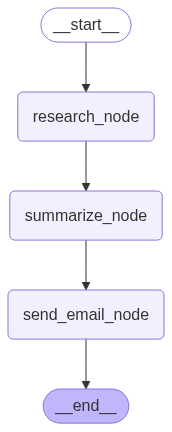

In [642]:
from IPython.display import Image, display

# Generate Mermaid PNG image of the compiled workflow
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("❌ Graph rendering failed. Ensure required dependencies are installed.")
    print(e)


# use dill == Use dill to save the agent safely

In [643]:
#  Cell 7: Use dill to save the agent safely
import dill

with open("automation_agent.pkl", "wb") as f:
    dill.dump(app, f)


# Create CSV with sample emails

In [644]:
#  Cell 8: Create CSV with sample emails
import pandas as pd

df = pd.DataFrame({
    "email": ["aryan914078@gmail.com",  "aryanpatel77462@gmail.com.com" , "arya230101047@iiitmanipur.ac.in"]
})


df.to_csv("emails.csv", index=False)


In [645]:
# df = pd.read_csv("emails.csv")

# df

In [646]:
# Test with CSV-loaded email list
import pandas as pd

emails = pd.read_csv("emails.csv")["email"].dropna().tolist()

app.invoke({
    "input": "What is generative AI?",
    "wiki": "",
    "arxiv": "",
    "summary": "",
    "email_list": emails
})



{'input': 'What is generative AI?',
 'wiki': '',
 'arxiv': '',
 'summary': '',
 'email_list': ['aryan914078@gmail.com',
  'aryanpatel77462@gmail.com.com',
  'arya230101047@iiitmanipur.ac.in']}